In [23]:
# Import the QICK drivers and auxiliary libraries
from qick import *
import time, math
%pylab inline
soc = QickSoc("/home/xilinx/jupyter_notebooks/qick/firmware/top_216_bitstream/d_1.bit")
soccfg = soc
print(soccfg)
GEN_CH = 0
RO_CH = 0
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]
        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])
        sig_mode = "oneshot"
        if "mode" in cfg:
            sig_mode = (sig_mode, cfg["mode"])[cfg["mode"] == "periodic"]
        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)
        style=self.cfg["pulse_style"]
        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma*2, length=sigma*7)
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"], mode=sig_mode)
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", mode=sig_mode)
        self.synci(200)  # give processor some time to configure pulses
    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
class DoublePulseProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        gain = cfg["pulse_gain"]
        sig_mode = "oneshot"
        if "mode" in cfg:
            sig_mode = (sig_mode, cfg["mode"])[cfg["mode"] == "periodic"]

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.default_pulse_registers(ch=res_ch, style=style, freq=freq, gain=gain, 
                                         length=cfg["length"], mode=sig_mode)
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.default_pulse_registers(ch=res_ch, style=style, freq=freq, gain=gain, 
                                         waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.default_pulse_registers(ch=res_ch, style=style, freq=freq, gain=gain, 
                                         waveform="measure", mode=sig_mode)
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        phase1 = self.deg2reg(self.cfg["res_phase"], gen_ch=self.cfg["res_ch"])
        phase2 = self.deg2reg(self.cfg["res_phase"]+90, gen_ch=self.cfg["res_ch"])
        # fire a single trigger, but two pulses offset by 200 tProc clock ticks
        # with the first ADC trigger, pulse PMOD0_0 for a scope trigger
        # after the full sequence is set up, pause the tProc until readout is done
        # and increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        self.set_pulse_registers(ch=self.cfg["res_ch"], phase=phase1)
        self.pulse(ch=self.cfg["res_ch"], t=0)
        self.set_pulse_registers(ch=self.cfg["res_ch"], phase=phase2)
        self.pulse(ch=self.cfg["res_ch"], t=200)
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: ZCU216

	Software version: 0.2.268
	Firmware timestamp: Thu Aug  1 12:21:36 2024

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope m

In [24]:
axi_read_address = 0xa0018000
axi_read_range = 0x1000
import pynq
mmio = pynq.MMIO(axi_read_address, axi_read_range)
mmio.write(4, int(time.time_ns()) % 32768)
read_output = []
for axi_writ_offset in range(16):
    mmio.write(0, 15 - axi_writ_offset)
    # print(str(15 - axi_writ_offset)+":\t0x" + (lambda x: x[:4] + "_" + x[4:])(hex(mmio.read(0, 4))[2:].zfill(8)))
    read_output.append(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"))
# print(read_output)
output_info = []
gauss_a = str(math.pow(int(read_output[0] + read_output[1], 16), 0.5))[:8] + " = " + str(int(read_output[0] + read_output[1], 16)) + " ^ 0.5"
output_info.append("Measured Gaussian a\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
gauss_b = str(int(read_output[2] + read_output[3], 16)) + " = " + hex(int(read_output[2] + read_output[3], 16))
output_info.append("Measured Gaussian b\ty = a * exp(-(x - b)^2 / (2c^2))\tint\t")
gauss_c = str(int(read_output[4] + read_output[5], 16) / (2 * math.pow(2 * math.log(2), 0.5)))[:8] + " = (2ln2)^(-0.5) * " + str(int(read_output[4] + read_output[5], 16))
output_info.append("Measured Gaussian c\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
status_flag_past = bin(int(read_output[6][0], 16))[2:].zfill(4)
output_info.append("Prior 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
status_flag_now_ = bin(int(read_output[6][1], 16))[2:].zfill(4)
output_info.append("Current 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp = (lambda x: (x[3], x[4], x[5], int(x[6:8], 2), int(x[8:], 2)))(bin(int(read_output[6][2:] + read_output[7], 16))[2:].zfill(24))
output_info.append("FIFO - phase reset\t1 resets accumulator coherency\t\tbool\t")
output_info.append("FIFO - steady state\t1 sets final value at 0, else last\tbool\t")
output_info.append("FIFO - repeat waveform\t0 outputs # of pulses according to reps\tbool\t")
output_info.append("FIFO - output mode\t0: prod, 1: DDS, 2:input, 3:zero\tbool\t")
output_info.append("FIFO - sample meas\t# of repeated pulse output\t\tint\t")
fifo_gain = int(read_output[9], 16)
output_info.append("FIFO - software gain\tamplitude set from software\t\tint\t")
fifo_addr = int(read_output[11], 16)
output_info.append("FIFO - address\t\taddress set from software\t\tint\t")
fifo_phas = int(read_output[12] + read_output[13], 16)
output_info.append("FIFO - phase\t\tphase offset from software\t\tint\t")
fifo_freq = int(read_output[14] + read_output[15], 16)
output_info.append("FIFO - frequency\tfrequency value set from software\tint\t")
refined_output = [gauss_a, gauss_b, gauss_c, status_flag_past, status_flag_now_, fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp, fifo_gain, fifo_addr, fifo_phas, fifo_freq]
for z, output_item in enumerate(refined_output):
    print(output_info[z] + str(output_item))

Measured Gaussian a	y = a * exp(-(x - b)^2 / (2c^2))	float	0.0 = 0 ^ 0.5
Measured Gaussian b	y = a * exp(-(x - b)^2 / (2c^2))	int	0 = 0x0
Measured Gaussian c	y = a * exp(-(x - b)^2 / (2c^2))	float	0.0 = (2ln2)^(-0.5) * 0
Prior 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	1111
Current 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	0000
FIFO - phase reset	1 resets accumulator coherency		bool	0
FIFO - steady state	1 sets final value at 0, else last	bool	0
FIFO - repeat waveform	0 outputs # of pulses according to reps	bool	0
FIFO - output mode	0: prod, 1: DDS, 2:input, 3:zero	bool	0
FIFO - sample meas	# of repeated pulse output		int	0
FIFO - software gain	amplitude set from software		int	0
FIFO - address		address set from software		int	0
FIFO - phase		phase offset from software		int	0
FIFO - frequency	frequency value set from software	int	0


  0%|          | 0/100 [00:00<?, ?it/s]

Attempting to read memory.
Measured Gaussian a	y = a * exp(-(x - b)^2 / (2c^2))	float	0.0 = 0 ^ 0.5
Measured Gaussian b	y = a * exp(-(x - b)^2 / (2c^2))	int	0 = 0x0
Measured Gaussian c	y = a * exp(-(x - b)^2 / (2c^2))	float	0.0 = (2ln2)^(-0.5) * 0
Prior 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	1111
Current 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	0101
FIFO - phase reset	1 resets accumulator coherency		bool	0
FIFO - steady state	1 sets final value at 0, else last	bool	1
FIFO - repeat waveform	0 outputs # of pulses according to reps	bool	0
FIFO - output mode	0: prod, 1: DDS, 2:input, 3:zero	bool	0
FIFO - sample meas	# of repeated pulse output		int	35
FIFO - software gain	amplitude set from software		int	32000
FIFO - address		address set from software		int	35
FIFO - phase		phase offset from software		int	0
FIFO - frequency	frequency value set from software	int	124830475


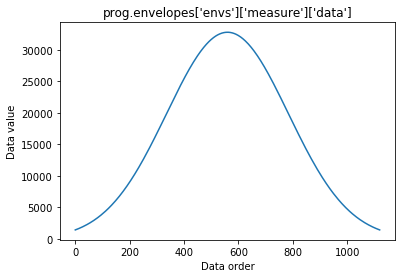

In [25]:
# this used the old self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
# the new one used sigma*2 and sigma*7
# double pulse still used sigma and sigma*5
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "flat_top", # --Fixed
        "length": 10, # [Clock ticks]
        # Try varying  length from 10-100 clock ticks
        "sigma": 10, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":50, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":32000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units
        # DAC at 30000 corresponds to ~400 mV Vpp centered on 0 with input impedance 1M ohm, 1x probe, DC coupling

        "pulse_freq": 200, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages
       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)
time.sleep(1)
do_read = True
if "mode" in config:
    if config["mode"] == "periodic" and config["pulse_style"] != "flat_top":
        do_read = False
if do_read:
    if do_read:
        print("Attempting to read memory.")
        axi_read_address = 0xa0018000
        axi_read_range = 0x1000
        import pynq
        mmio = pynq.MMIO(axi_read_address, axi_read_range)
        mmio_result = ""
        mmio.write(0, 15 - 6)
        counter = 0
        while mmio_result != "1111":
            mmio.write(4, int(time.time_ns()) % 2413083)
            counter = (counter + 1) % 65536
            mmio_result = bin(int(hex(mmio.read(0, 4))[-4:].zfill(4)[0], 16))[2:].zfill(4)
            if counter % 65536 == 0:
                print(mmio_result)
        read_output = []
        for axi_writ_offset in range(16):
            mmio.write(0, 15 - axi_writ_offset)
            # print(str(15 - axi_writ_offset)+":\t0x" + (lambda x: x[:4] + "_" + x[4:])(hex(mmio.read(0, 4))[2:].zfill(8)))
            read_output.append(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"))
        # print(read_output)
        output_info = []
        gauss_a = str(math.pow(int(read_output[0] + read_output[1], 16), 0.5))[:8] + " = " + str(int(read_output[0] + read_output[1], 16)) + " ^ 0.5"
        output_info.append("Measured Gaussian a\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
        gauss_b = str(int(read_output[2] + read_output[3], 16)) + " = " + hex(int(read_output[2] + read_output[3], 16))
        output_info.append("Measured Gaussian b\ty = a * exp(-(x - b)^2 / (2c^2))\tint\t")
        gauss_c = str(int(read_output[4] + read_output[5], 16) / (2 * math.pow(2 * math.log(2), 0.5)))[:8] + " = (2ln2)^(-0.5) * " + str(int(read_output[4] + read_output[5], 16))
        output_info.append("Measured Gaussian c\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
        status_flag_past = bin(int(read_output[6][0], 16))[2:].zfill(4)
        output_info.append("Prior 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
        status_flag_now_ = bin(int(read_output[6][1], 16))[2:].zfill(4)
        output_info.append("Current 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
        fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp = (lambda x: (x[3], x[4], x[5], int(x[6:8], 2), int(x[8:], 2)))(bin(int(read_output[6][2:] + read_output[7], 16))[2:].zfill(24))
        output_info.append("FIFO - phase reset\t1 resets accumulator coherency\t\tbool\t")
        output_info.append("FIFO - steady state\t1 sets final value at 0, else last\tbool\t")
        output_info.append("FIFO - repeat waveform\t0 outputs # of pulses according to reps\tbool\t")
        output_info.append("FIFO - output mode\t0: prod, 1: DDS, 2:input, 3:zero\tbool\t")
        output_info.append("FIFO - sample meas\t# of repeated pulse output\t\tint\t")
        fifo_gain = int(read_output[9], 16)
        output_info.append("FIFO - software gain\tamplitude set from software\t\tint\t")
        fifo_addr = int(read_output[11], 16)
        output_info.append("FIFO - address\t\taddress set from software\t\tint\t")
        fifo_phas = int(read_output[12] + read_output[13], 16)
        output_info.append("FIFO - phase\t\tphase offset from software\t\tint\t")
        fifo_freq = int(read_output[14] + read_output[15], 16)
        output_info.append("FIFO - frequency\tfrequency value set from software\tint\t")
        refined_output = [gauss_a, gauss_b, gauss_c, status_flag_past, status_flag_now_, fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp, fifo_gain, fifo_addr, fifo_phas, fifo_freq]
        for z, output_item in enumerate(refined_output):
            print(output_info[z] + str(output_item))
graph_made = False
for env_entity in prog.envelopes:
    if "measure" in env_entity["envs"]:
        plt.figure(1)
        plt.plot(*zip(*enumerate([x[0] for x in env_entity["envs"]["measure"]["data"]])))
        plt.xlabel("Data order")
        plt.ylabel("Data value")
        plt.title("prog.envelopes[\'envs\'][\'measure\'][\'data\']")
        graph_made = True
if not graph_made:
    print("\nFound nothing on prog.envelopes list")

  0%|          | 0/100 [00:00<?, ?it/s]

Attempting to read memory.
Measured Gaussian a	y = a * exp(-(x - b)^2 / (2c^2))	float	94.49867 = 8930 ^ 0.5
Measured Gaussian b	y = a * exp(-(x - b)^2 / (2c^2))	int	1073742081 = 0x40000101
Measured Gaussian c	y = a * exp(-(x - b)^2 / (2c^2))	float	0.849321 = (2ln2)^(-0.5) * 2
Prior 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	1111
Current 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	0000
FIFO - phase reset	1 resets accumulator coherency		bool	0
FIFO - steady state	1 sets final value at 0, else last	bool	1
FIFO - repeat waveform	0 outputs # of pulses according to reps	bool	0
FIFO - output mode	0: prod, 1: DDS, 2:input, 3:zero	bool	0
FIFO - sample meas	# of repeated pulse output		int	245
FIFO - software gain	amplitude set from software		int	12000
FIFO - address		address set from software		int	0
FIFO - phase		phase offset from software		int	0
FIFO - frequency	frequency value set from software	int	156038095


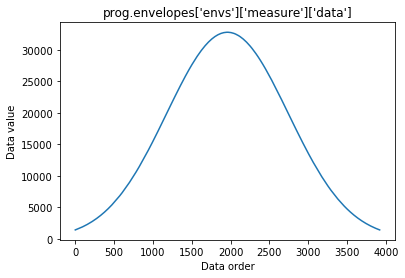

In [6]:
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "arb", # --Fixed
        
        "sigma": 35, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":300, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":12000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units
        # DAC at 30000 corresponds to ~400 mV Vpp centered on 0 with input impedance 1M ohm, 1x probe, DC coupling

        "pulse_freq": 250, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)
time.sleep(1)
do_read = True
if "mode" in config:
    if config["mode"] == "periodic" and config["pulse_style"] != "flat_top":
        do_read = False
if do_read:
    if do_read:
        print("Attempting to read memory.")
        axi_read_address = 0xa0018000
        axi_read_range = 0x1000
        import pynq
        mmio = pynq.MMIO(axi_read_address, axi_read_range)
        mmio_result = ""
        mmio.write(0, 15 - 6)
        counter = 0
        while mmio_result != "1111":
            mmio.write(4, int(time.time_ns()) % 2413083)
            counter = (counter + 1) % 65536
            mmio_result = bin(int(hex(mmio.read(0, 4))[-4:].zfill(4)[0], 16))[2:].zfill(4)
            if counter % 65536 == 0:
                print(mmio_result)
        read_output = []
        for axi_writ_offset in range(16):
            mmio.write(0, 15 - axi_writ_offset)
            # print(str(15 - axi_writ_offset)+":\t0x" + (lambda x: x[:4] + "_" + x[4:])(hex(mmio.read(0, 4))[2:].zfill(8)))
            read_output.append(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"))
        # print(read_output)
        output_info = []
        gauss_a = str(math.pow(int(read_output[0] + read_output[1], 16), 0.5))[:8] + " = " + str(int(read_output[0] + read_output[1], 16)) + " ^ 0.5"
        output_info.append("Measured Gaussian a\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
        gauss_b = str(int(read_output[2] + read_output[3], 16)) + " = " + hex(int(read_output[2] + read_output[3], 16))
        output_info.append("Measured Gaussian b\ty = a * exp(-(x - b)^2 / (2c^2))\tint\t")
        gauss_c = str(int(read_output[4] + read_output[5], 16) / (2 * math.pow(2 * math.log(2), 0.5)))[:8] + " = (2ln2)^(-0.5) * " + str(int(read_output[4] + read_output[5], 16))
        output_info.append("Measured Gaussian c\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
        status_flag_past = bin(int(read_output[6][0], 16))[2:].zfill(4)
        output_info.append("Prior 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
        status_flag_now_ = bin(int(read_output[6][1], 16))[2:].zfill(4)
        output_info.append("Current 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
        fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp = (lambda x: (x[3], x[4], x[5], int(x[6:8], 2), int(x[8:], 2)))(bin(int(read_output[6][2:] + read_output[7], 16))[2:].zfill(24))
        output_info.append("FIFO - phase reset\t1 resets accumulator coherency\t\tbool\t")
        output_info.append("FIFO - steady state\t1 sets final value at 0, else last\tbool\t")
        output_info.append("FIFO - repeat waveform\t0 outputs # of pulses according to reps\tbool\t")
        output_info.append("FIFO - output mode\t0: prod, 1: DDS, 2:input, 3:zero\tbool\t")
        output_info.append("FIFO - sample meas\t# of repeated pulse output\t\tint\t")
        fifo_gain = int(read_output[9], 16)
        output_info.append("FIFO - software gain\tamplitude set from software\t\tint\t")
        fifo_addr = int(read_output[11], 16)
        output_info.append("FIFO - address\t\taddress set from software\t\tint\t")
        fifo_phas = int(read_output[12] + read_output[13], 16)
        output_info.append("FIFO - phase\t\tphase offset from software\t\tint\t")
        fifo_freq = int(read_output[14] + read_output[15], 16)
        output_info.append("FIFO - frequency\tfrequency value set from software\tint\t")
        refined_output = [gauss_a, gauss_b, gauss_c, status_flag_past, status_flag_now_, fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp, fifo_gain, fifo_addr, fifo_phas, fifo_freq]
        for z, output_item in enumerate(refined_output):
            print(output_info[z] + str(output_item))
graph_made = False
for env_entity in prog.envelopes:
    if "measure" in env_entity["envs"]:
        plt.figure(1)
        plt.plot(*zip(*enumerate([x[0] for x in env_entity["envs"]["measure"]["data"]])))
        plt.xlabel("Data order")
        plt.ylabel("Data value")
        plt.title("prog.envelopes[\'envs\'][\'measure\'][\'data\']")
        graph_made = True
if not graph_made:
    print("\nFound nothing on prog.envelopes list")

In [8]:
# for z in range(5):
#     print("Wait for "+str(5 - z)+" seconds...")
#     time.sleep(1)
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":10, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":28000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 128, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)
time.sleep(1)
do_read = True
if "mode" in config:
    if config["mode"] == "periodic" and config["pulse_style"] != "flat_top":
        do_read = False
if do_read:
    if do_read:
        print("Attempting to read memory.")
        axi_read_address = 0xa0018000
        axi_read_range = 0x1000
        import pynq
        mmio = pynq.MMIO(axi_read_address, axi_read_range)
        mmio_result = ""
        mmio.write(0, 15 - 6)
        counter = 0
        while mmio_result != "1111":
            mmio.write(4, int(time.time_ns()) % 2413083)
            counter = (counter + 1) % 65536
            mmio_result = bin(int(hex(mmio.read(0, 4))[-4:].zfill(4)[0], 16))[2:].zfill(4)
            if counter % 65536 == 0:
                print(mmio_result)
        read_output = []
        for axi_writ_offset in range(16):
            mmio.write(0, 15 - axi_writ_offset)
            # print(str(15 - axi_writ_offset)+":\t0x" + (lambda x: x[:4] + "_" + x[4:])(hex(mmio.read(0, 4))[2:].zfill(8)))
            read_output.append(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"))
        # print(read_output)
        output_info = []
        gauss_a = str(math.pow(int(read_output[0] + read_output[1], 16), 0.5))[:8] + " = " + str(int(read_output[0] + read_output[1], 16)) + " ^ 0.5"
        output_info.append("Measured Gaussian a\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
        gauss_b = str(int(read_output[2] + read_output[3], 16)) + " = " + hex(int(read_output[2] + read_output[3], 16))
        output_info.append("Measured Gaussian b\ty = a * exp(-(x - b)^2 / (2c^2))\tint\t")
        gauss_c = str(int(read_output[4] + read_output[5], 16) / (2 * math.pow(2 * math.log(2), 0.5)))[:8] + " = (2ln2)^(-0.5) * " + str(int(read_output[4] + read_output[5], 16))
        output_info.append("Measured Gaussian c\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
        status_flag_past = bin(int(read_output[6][0], 16))[2:].zfill(4)
        output_info.append("Prior 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
        status_flag_now_ = bin(int(read_output[6][1], 16))[2:].zfill(4)
        output_info.append("Current 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
        fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp = (lambda x: (x[3], x[4], x[5], int(x[6:8], 2), int(x[8:], 2)))(bin(int(read_output[6][2:] + read_output[7], 16))[2:].zfill(24))
        output_info.append("FIFO - phase reset\t1 resets accumulator coherency\t\tbool\t")
        output_info.append("FIFO - steady state\t1 sets final value at 0, else last\tbool\t")
        output_info.append("FIFO - repeat waveform\t0 outputs # of pulses according to reps\tbool\t")
        output_info.append("FIFO - output mode\t0: prod, 1: DDS, 2:input, 3:zero\tbool\t")
        output_info.append("FIFO - sample meas\t# of repeated pulse output\t\tint\t")
        fifo_gain = int(read_output[9], 16)
        output_info.append("FIFO - software gain\tamplitude set from software\t\tint\t")
        fifo_addr = int(read_output[11], 16)
        output_info.append("FIFO - address\t\taddress set from software\t\tint\t")
        fifo_phas = int(read_output[12] + read_output[13], 16)
        output_info.append("FIFO - phase\t\tphase offset from software\t\tint\t")
        fifo_freq = int(read_output[14] + read_output[15], 16)
        output_info.append("FIFO - frequency\tfrequency value set from software\tint\t")
        refined_output = [gauss_a, gauss_b, gauss_c, status_flag_past, status_flag_now_, fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp, fifo_gain, fifo_addr, fifo_phas, fifo_freq]
        for z, output_item in enumerate(refined_output):
            print(output_info[z] + str(output_item))
graph_made = False
for env_entity in prog.envelopes:
    if "measure" in env_entity["envs"]:
        plt.figure(1)
        plt.plot(*zip(*enumerate([x[0] for x in env_entity["envs"]["measure"]["data"]])))
        plt.xlabel("Data order")
        plt.ylabel("Data value")
        plt.title("prog.envelopes[\'envs\'][\'measure\'][\'data\']")
        graph_made = True
if not graph_made:
    print("\nFound nothing on prog.envelopes list")

  0%|          | 0/100 [00:00<?, ?it/s]

Attempting to read memory.
Measured Gaussian a	y = a * exp(-(x - b)^2 / (2c^2))	float	94.49867 = 8930 ^ 0.5
Measured Gaussian b	y = a * exp(-(x - b)^2 / (2c^2))	int	1073742081 = 0x40000101
Measured Gaussian c	y = a * exp(-(x - b)^2 / (2c^2))	float	0.849321 = (2ln2)^(-0.5) * 2
Prior 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	1111
Current 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	0000
FIFO - phase reset	1 resets accumulator coherency		bool	0
FIFO - steady state	1 sets final value at 0, else last	bool	1
FIFO - repeat waveform	0 outputs # of pulses according to reps	bool	0
FIFO - output mode	0: prod, 1: DDS, 2:input, 3:zero	bool	1
FIFO - sample meas	# of repeated pulse output		int	20
FIFO - software gain	amplitude set from software		int	28000
FIFO - address		address set from software		int	0
FIFO - phase		phase offset from software		int	0
FIFO - frequency	frequency value set from software	int	79891505

Found nothing on prog.envelopes list


  0%|          | 0/100 [00:00<?, ?it/s]

Attempting to read memory.
Measured Gaussian a	y = a * exp(-(x - b)^2 / (2c^2))	float	5.099019 = 26 ^ 0.5
Measured Gaussian b	y = a * exp(-(x - b)^2 / (2c^2))	int	1140850945 = 0x44000101
Measured Gaussian c	y = a * exp(-(x - b)^2 / (2c^2))	float	0.849321 = (2ln2)^(-0.5) * 2
Prior 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	1111
Current 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	0000
FIFO - phase reset	1 resets accumulator coherency		bool	0
FIFO - steady state	1 sets final value at 0, else last	bool	1
FIFO - repeat waveform	0 outputs # of pulses according to reps	bool	0
FIFO - output mode	0: prod, 1: DDS, 2:input, 3:zero	bool	0
FIFO - sample meas	# of repeated pulse output		int	175
FIFO - software gain	amplitude set from software		int	26500
FIFO - address		address set from software		int	0
FIFO - phase		phase offset from software		int	0
FIFO - frequency	frequency value set from software	int	137313525


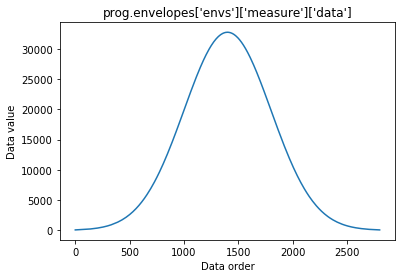

In [9]:
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "arb", # --Fixed
        #"mode": "periodic",
        "sigma": 20, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":300, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":26500, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units
        # DAC at 30000 corresponds to ~400 mV Vpp centered on 0 with input impedance 1M ohm, 1x probe, DC coupling

        "pulse_freq": 220, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

prog = DoublePulseProgram(soccfg, config)
# print(prog.acquire(soc))
# print(prog.di_buf)
iq_list = prog.acquire_decimated(soc)
time.sleep(1)
do_read = True
if "mode" in config:
    if config["mode"] == "periodic" and config["pulse_style"] != "flat_top":
        do_read = False
if do_read:
    if do_read:
        print("Attempting to read memory.")
        axi_read_address = 0xa0018000
        axi_read_range = 0x1000
        import pynq
        mmio = pynq.MMIO(axi_read_address, axi_read_range)
        mmio_result = ""
        mmio.write(0, 15 - 6)
        counter = 0
        while mmio_result != "1111":
            mmio.write(4, int(time.time_ns()) % 2413083)
            counter = (counter + 1) % 65536
            mmio_result = bin(int(hex(mmio.read(0, 4))[-4:].zfill(4)[0], 16))[2:].zfill(4)
            if counter % 65536 == 0:
                print(mmio_result)
        read_output = []
        for axi_writ_offset in range(16):
            mmio.write(0, 15 - axi_writ_offset)
            # print(str(15 - axi_writ_offset)+":\t0x" + (lambda x: x[:4] + "_" + x[4:])(hex(mmio.read(0, 4))[2:].zfill(8)))
            read_output.append(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"))
        # print(read_output)
        output_info = []
        gauss_a = str(math.pow(int(read_output[0] + read_output[1], 16), 0.5))[:8] + " = " + str(int(read_output[0] + read_output[1], 16)) + " ^ 0.5"
        output_info.append("Measured Gaussian a\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
        gauss_b = str(int(read_output[2] + read_output[3], 16)) + " = " + hex(int(read_output[2] + read_output[3], 16))
        output_info.append("Measured Gaussian b\ty = a * exp(-(x - b)^2 / (2c^2))\tint\t")
        gauss_c = str(int(read_output[4] + read_output[5], 16) / (2 * math.pow(2 * math.log(2), 0.5)))[:8] + " = (2ln2)^(-0.5) * " + str(int(read_output[4] + read_output[5], 16))
        output_info.append("Measured Gaussian c\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
        status_flag_past = bin(int(read_output[6][0], 16))[2:].zfill(4)
        output_info.append("Prior 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
        status_flag_now_ = bin(int(read_output[6][1], 16))[2:].zfill(4)
        output_info.append("Current 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
        fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp = (lambda x: (x[3], x[4], x[5], int(x[6:8], 2), int(x[8:], 2)))(bin(int(read_output[6][2:] + read_output[7], 16))[2:].zfill(24))
        output_info.append("FIFO - phase reset\t1 resets accumulator coherency\t\tbool\t")
        output_info.append("FIFO - steady state\t1 sets final value at 0, else last\tbool\t")
        output_info.append("FIFO - repeat waveform\t0 outputs # of pulses according to reps\tbool\t")
        output_info.append("FIFO - output mode\t0: prod, 1: DDS, 2:input, 3:zero\tbool\t")
        output_info.append("FIFO - sample meas\t# of repeated pulse output\t\tint\t")
        fifo_gain = int(read_output[9], 16)
        output_info.append("FIFO - software gain\tamplitude set from software\t\tint\t")
        fifo_addr = int(read_output[11], 16)
        output_info.append("FIFO - address\t\taddress set from software\t\tint\t")
        fifo_phas = int(read_output[12] + read_output[13], 16)
        output_info.append("FIFO - phase\t\tphase offset from software\t\tint\t")
        fifo_freq = int(read_output[14] + read_output[15], 16)
        output_info.append("FIFO - frequency\tfrequency value set from software\tint\t")
        refined_output = [gauss_a, gauss_b, gauss_c, status_flag_past, status_flag_now_, fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp, fifo_gain, fifo_addr, fifo_phas, fifo_freq]
        for z, output_item in enumerate(refined_output):
            print(output_info[z] + str(output_item))
graph_made = False
#print(prog.envelopes)
for env_entity in prog.envelopes:
    if "measure" in env_entity["envs"]:
        plt.figure(1)
        plt.plot(*zip(*enumerate([x[0] for x in env_entity["envs"]["measure"]["data"]])))
        plt.xlabel("Data order")
        plt.ylabel("Data value")
        plt.title("prog.envelopes[\'envs\'][\'measure\'][\'data\']")
        graph_made = True
if not graph_made:
    print("\nFound nothing on prog.envelopes list")

  0%|          | 0/100 [00:00<?, ?it/s]

Attempting to read memory.
Measured Gaussian a	y = a * exp(-(x - b)^2 / (2c^2))	float	5.099019 = 26 ^ 0.5
Measured Gaussian b	y = a * exp(-(x - b)^2 / (2c^2))	int	1140850945 = 0x44000101
Measured Gaussian c	y = a * exp(-(x - b)^2 / (2c^2))	float	0.849321 = (2ln2)^(-0.5) * 2
Prior 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	1111
Current 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	0000
FIFO - phase reset	1 resets accumulator coherency		bool	0
FIFO - steady state	1 sets final value at 0, else last	bool	1
FIFO - repeat waveform	0 outputs # of pulses according to reps	bool	0
FIFO - output mode	0: prod, 1: DDS, 2:input, 3:zero	bool	0
FIFO - sample meas	# of repeated pulse output		int	175
FIFO - software gain	amplitude set from software		int	32000
FIFO - address		address set from software		int	0
FIFO - phase		phase offset from software		int	0
FIFO - frequency	frequency value set from software	int	156038095


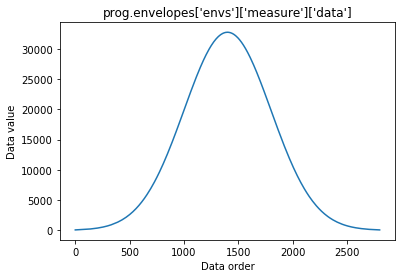

In [14]:
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "arb", # --Fixed
        "sigma": 35, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":300, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":32000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units
        # DAC at 30000 corresponds to ~400 mV Vpp centered on 0 with input impedance 1M ohm, 1x probe, DC coupling

        "pulse_freq": 250, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

prog = DoublePulseProgram(soccfg, config)
# print(prog.acquire(soc))
# print(prog.di_buf)
iq_list = prog.acquire_decimated(soc)
time.sleep(1)
do_read = True
if "mode" in config:
    if config["mode"] == "periodic" and config["pulse_style"] != "flat_top":
        do_read = False
if do_read:
    if do_read:
        print("Attempting to read memory.")
        axi_read_address = 0xa0018000
        axi_read_range = 0x1000
        import pynq
        mmio = pynq.MMIO(axi_read_address, axi_read_range)
        mmio_result = ""
        mmio.write(0, 15 - 6)
        counter = 0
        while mmio_result != "1111":
            mmio.write(4, int(time.time_ns()) % 2413083)
            counter = (counter + 1) % 65536
            mmio_result = bin(int(hex(mmio.read(0, 4))[-4:].zfill(4)[0], 16))[2:].zfill(4)
            if counter % 65536 == 0:
                print(mmio_result)
        read_output = []
        for axi_writ_offset in range(16):
            mmio.write(0, 15 - axi_writ_offset)
            # print(str(15 - axi_writ_offset)+":\t0x" + (lambda x: x[:4] + "_" + x[4:])(hex(mmio.read(0, 4))[2:].zfill(8)))
            read_output.append(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"))
        # print(read_output)
        output_info = []
        gauss_a = str(math.pow(int(read_output[0] + read_output[1], 16), 0.5))[:8] + " = " + str(int(read_output[0] + read_output[1], 16)) + " ^ 0.5"
        output_info.append("Measured Gaussian a\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
        gauss_b = str(int(read_output[2] + read_output[3], 16)) + " = " + hex(int(read_output[2] + read_output[3], 16))
        output_info.append("Measured Gaussian b\ty = a * exp(-(x - b)^2 / (2c^2))\tint\t")
        gauss_c = str(int(read_output[4] + read_output[5], 16) / (2 * math.pow(2 * math.log(2), 0.5)))[:8] + " = (2ln2)^(-0.5) * " + str(int(read_output[4] + read_output[5], 16))
        output_info.append("Measured Gaussian c\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
        status_flag_past = bin(int(read_output[6][0], 16))[2:].zfill(4)
        output_info.append("Prior 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
        status_flag_now_ = bin(int(read_output[6][1], 16))[2:].zfill(4)
        output_info.append("Current 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
        fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp = (lambda x: (x[3], x[4], x[5], int(x[6:8], 2), int(x[8:], 2)))(bin(int(read_output[6][2:] + read_output[7], 16))[2:].zfill(24))
        output_info.append("FIFO - phase reset\t1 resets accumulator coherency\t\tbool\t")
        output_info.append("FIFO - steady state\t1 sets final value at 0, else last\tbool\t")
        output_info.append("FIFO - repeat waveform\t0 outputs # of pulses according to reps\tbool\t")
        output_info.append("FIFO - output mode\t0: prod, 1: DDS, 2:input, 3:zero\tbool\t")
        output_info.append("FIFO - sample meas\t# of repeated pulse output\t\tint\t")
        fifo_gain = int(read_output[9], 16)
        output_info.append("FIFO - software gain\tamplitude set from software\t\tint\t")
        fifo_addr = int(read_output[11], 16)
        output_info.append("FIFO - address\t\taddress set from software\t\tint\t")
        fifo_phas = int(read_output[12] + read_output[13], 16)
        output_info.append("FIFO - phase\t\tphase offset from software\t\tint\t")
        fifo_freq = int(read_output[14] + read_output[15], 16)
        output_info.append("FIFO - frequency\tfrequency value set from software\tint\t")
        refined_output = [gauss_a, gauss_b, gauss_c, status_flag_past, status_flag_now_, fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp, fifo_gain, fifo_addr, fifo_phas, fifo_freq]
        for z, output_item in enumerate(refined_output):
            print(output_info[z] + str(output_item))
graph_made = False
#print(prog.envelopes)
for env_entity in prog.envelopes:
    if "measure" in env_entity["envs"]:
        plt.figure(1)
        plt.plot(*zip(*enumerate([x[0] for x in env_entity["envs"]["measure"]["data"]])))
        plt.xlabel("Data order")
        plt.ylabel("Data value")
        plt.title("prog.envelopes[\'envs\'][\'measure\'][\'data\']")
        graph_made = True
if not graph_made:
    print("\nFound nothing on prog.envelopes list")

  0%|          | 0/100 [00:00<?, ?it/s]

Attempting to read memory.
Measured Gaussian a	y = a * exp(-(x - b)^2 / (2c^2))	float	2047.874 = 4193792 ^ 0.5
Measured Gaussian b	y = a * exp(-(x - b)^2 / (2c^2))	int	67109121 = 0x4000101
Measured Gaussian c	y = a * exp(-(x - b)^2 / (2c^2))	float	0.849321 = (2ln2)^(-0.5) * 2
Prior 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	1111
Current 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	0000
FIFO - phase reset	1 resets accumulator coherency		bool	0
FIFO - steady state	1 sets final value at 0, else last	bool	1
FIFO - repeat waveform	0 outputs # of pulses according to reps	bool	0
FIFO - output mode	0: prod, 1: DDS, 2:input, 3:zero	bool	0
FIFO - sample meas	# of repeated pulse output		int	25
FIFO - software gain	amplitude set from software		int	32000
FIFO - address		address set from software		int	25
FIFO - phase		phase offset from software		int	0
FIFO - frequency	frequency value set from software	int	124830475


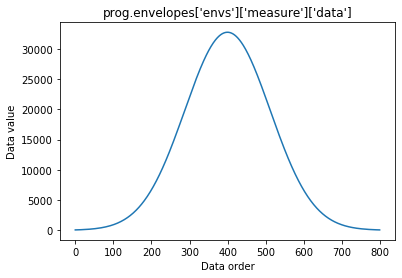

In [20]:
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "flat_top", # --Fixed
        "length": 10, # [Clock ticks]
        # Try varying  length from 10-100 clock ticks
        "sigma": 10, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":50, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":32000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units
        # DAC at 30000 corresponds to ~400 mV Vpp centered on 0 with input impedance 1M ohm, 1x probe, DC coupling

        "pulse_freq": 200, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages
       }
prog = DoublePulseProgram(soccfg, config)
# print(prog.acquire(soc))
# print(prog.di_buf)
iq_list = prog.acquire_decimated(soc)
time.sleep(1)
do_read = True
if "mode" in config:
    if config["mode"] == "periodic" and config["pulse_style"] != "flat_top":
        do_read = False
if do_read:
    if do_read:
        print("Attempting to read memory.")
        axi_read_address = 0xa0018000
        axi_read_range = 0x1000
        import pynq
        mmio = pynq.MMIO(axi_read_address, axi_read_range)
        mmio_result = ""
        mmio.write(0, 15 - 6)
        counter = 0
        while mmio_result != "1111":
            mmio.write(4, int(time.time_ns()) % 2413083)
            counter = (counter + 1) % 65536
            mmio_result = bin(int(hex(mmio.read(0, 4))[-4:].zfill(4)[0], 16))[2:].zfill(4)
            if counter % 65536 == 0:
                print(mmio_result)
        read_output = []
        for axi_writ_offset in range(16):
            mmio.write(0, 15 - axi_writ_offset)
            # print(str(15 - axi_writ_offset)+":\t0x" + (lambda x: x[:4] + "_" + x[4:])(hex(mmio.read(0, 4))[2:].zfill(8)))
            read_output.append(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"))
        # print(read_output)
        output_info = []
        gauss_a = str(math.pow(int(read_output[0] + read_output[1], 16), 0.5))[:8] + " = " + str(int(read_output[0] + read_output[1], 16)) + " ^ 0.5"
        output_info.append("Measured Gaussian a\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
        gauss_b = str(int(read_output[2] + read_output[3], 16)) + " = " + hex(int(read_output[2] + read_output[3], 16))
        output_info.append("Measured Gaussian b\ty = a * exp(-(x - b)^2 / (2c^2))\tint\t")
        gauss_c = str(int(read_output[4] + read_output[5], 16) / (2 * math.pow(2 * math.log(2), 0.5)))[:8] + " = (2ln2)^(-0.5) * " + str(int(read_output[4] + read_output[5], 16))
        output_info.append("Measured Gaussian c\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
        status_flag_past = bin(int(read_output[6][0], 16))[2:].zfill(4)
        output_info.append("Prior 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
        status_flag_now_ = bin(int(read_output[6][1], 16))[2:].zfill(4)
        output_info.append("Current 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
        fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp = (lambda x: (x[3], x[4], x[5], int(x[6:8], 2), int(x[8:], 2)))(bin(int(read_output[6][2:] + read_output[7], 16))[2:].zfill(24))
        output_info.append("FIFO - phase reset\t1 resets accumulator coherency\t\tbool\t")
        output_info.append("FIFO - steady state\t1 sets final value at 0, else last\tbool\t")
        output_info.append("FIFO - repeat waveform\t0 outputs # of pulses according to reps\tbool\t")
        output_info.append("FIFO - output mode\t0: prod, 1: DDS, 2:input, 3:zero\tbool\t")
        output_info.append("FIFO - sample meas\t# of repeated pulse output\t\tint\t")
        fifo_gain = int(read_output[9], 16)
        output_info.append("FIFO - software gain\tamplitude set from software\t\tint\t")
        fifo_addr = int(read_output[11], 16)
        output_info.append("FIFO - address\t\taddress set from software\t\tint\t")
        fifo_phas = int(read_output[12] + read_output[13], 16)
        output_info.append("FIFO - phase\t\tphase offset from software\t\tint\t")
        fifo_freq = int(read_output[14] + read_output[15], 16)
        output_info.append("FIFO - frequency\tfrequency value set from software\tint\t")
        refined_output = [gauss_a, gauss_b, gauss_c, status_flag_past, status_flag_now_, fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp, fifo_gain, fifo_addr, fifo_phas, fifo_freq]
        for z, output_item in enumerate(refined_output):
            print(output_info[z] + str(output_item))
graph_made = False
#print(prog.envelopes)
for env_entity in prog.envelopes:
    if "measure" in env_entity["envs"]:
        plt.figure(1)
        plt.plot(*zip(*enumerate([x[0] for x in env_entity["envs"]["measure"]["data"]])))
        plt.xlabel("Data order")
        plt.ylabel("Data value")
        plt.title("prog.envelopes[\'envs\'][\'measure\'][\'data\']")
        graph_made = True
if not graph_made:
    print("\nFound nothing on prog.envelopes list")

In [22]:
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":10, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":28000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 128, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }
prog = DoublePulseProgram(soccfg, config)
# print(prog.acquire(soc))
# print(prog.di_buf)
iq_list = prog.acquire_decimated(soc)
time.sleep(1)
do_read = True
if "mode" in config:
    if config["mode"] == "periodic" and config["pulse_style"] != "flat_top":
        do_read = False
if do_read:
    if do_read:
        print("Attempting to read memory.")
        axi_read_address = 0xa0018000
        axi_read_range = 0x1000
        import pynq
        mmio = pynq.MMIO(axi_read_address, axi_read_range)
        mmio_result = ""
        mmio.write(0, 15 - 6)
        counter = 0
        while mmio_result != "1111":
            mmio.write(4, int(time.time_ns()) % 2413083)
            counter = (counter + 1) % 65536
            mmio_result = bin(int(hex(mmio.read(0, 4))[-4:].zfill(4)[0], 16))[2:].zfill(4)
            if counter % 65536 == 0:
                print(mmio_result)
        read_output = []
        for axi_writ_offset in range(16):
            mmio.write(0, 15 - axi_writ_offset)
            # print(str(15 - axi_writ_offset)+":\t0x" + (lambda x: x[:4] + "_" + x[4:])(hex(mmio.read(0, 4))[2:].zfill(8)))
            read_output.append(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"))
        # print(read_output)
        output_info = []
        gauss_a = str(math.pow(int(read_output[0] + read_output[1], 16), 0.5))[:8] + " = " + str(int(read_output[0] + read_output[1], 16)) + " ^ 0.5"
        output_info.append("Measured Gaussian a\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
        gauss_b = str(int(read_output[2] + read_output[3], 16)) + " = " + hex(int(read_output[2] + read_output[3], 16))
        output_info.append("Measured Gaussian b\ty = a * exp(-(x - b)^2 / (2c^2))\tint\t")
        gauss_c = str(int(read_output[4] + read_output[5], 16) / (2 * math.pow(2 * math.log(2), 0.5)))[:8] + " = (2ln2)^(-0.5) * " + str(int(read_output[4] + read_output[5], 16))
        output_info.append("Measured Gaussian c\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
        status_flag_past = bin(int(read_output[6][0], 16))[2:].zfill(4)
        output_info.append("Prior 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
        status_flag_now_ = bin(int(read_output[6][1], 16))[2:].zfill(4)
        output_info.append("Current 4 flags\t\t(a != 0, y_max/2 <= y, la_1, la_0)\tbool[]\t")
        fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp = (lambda x: (x[3], x[4], x[5], int(x[6:8], 2), int(x[8:], 2)))(bin(int(read_output[6][2:] + read_output[7], 16))[2:].zfill(24))
        output_info.append("FIFO - phase reset\t1 resets accumulator coherency\t\tbool\t")
        output_info.append("FIFO - steady state\t1 sets final value at 0, else last\tbool\t")
        output_info.append("FIFO - repeat waveform\t0 outputs # of pulses according to reps\tbool\t")
        output_info.append("FIFO - output mode\t0: prod, 1: DDS, 2:input, 3:zero\tbool\t")
        output_info.append("FIFO - sample meas\t# of repeated pulse output\t\tint\t")
        fifo_gain = int(read_output[9], 16)
        output_info.append("FIFO - software gain\tamplitude set from software\t\tint\t")
        fifo_addr = int(read_output[11], 16)
        output_info.append("FIFO - address\t\taddress set from software\t\tint\t")
        fifo_phas = int(read_output[12] + read_output[13], 16)
        output_info.append("FIFO - phase\t\tphase offset from software\t\tint\t")
        fifo_freq = int(read_output[14] + read_output[15], 16)
        output_info.append("FIFO - frequency\tfrequency value set from software\tint\t")
        refined_output = [gauss_a, gauss_b, gauss_c, status_flag_past, status_flag_now_, fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp, fifo_gain, fifo_addr, fifo_phas, fifo_freq]
        for z, output_item in enumerate(refined_output):
            print(output_info[z] + str(output_item))
graph_made = False
#print(prog.envelopes)
for env_entity in prog.envelopes:
    if "measure" in env_entity["envs"]:
        plt.figure(1)
        plt.plot(*zip(*enumerate([x[0] for x in env_entity["envs"]["measure"]["data"]])))
        plt.xlabel("Data order")
        plt.ylabel("Data value")
        plt.title("prog.envelopes[\'envs\'][\'measure\'][\'data\']")
        graph_made = True
if not graph_made:
    print("\nFound nothing on prog.envelopes list")

  0%|          | 0/100 [00:00<?, ?it/s]

Attempting to read memory.
Measured Gaussian a	y = a * exp(-(x - b)^2 / (2c^2))	float	5.567764 = 31 ^ 0.5
Measured Gaussian b	y = a * exp(-(x - b)^2 / (2c^2))	int	2751463681 = 0xa4000101
Measured Gaussian c	y = a * exp(-(x - b)^2 / (2c^2))	float	0.849321 = (2ln2)^(-0.5) * 2
Prior 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	1111
Current 4 flags		(a != 0, y_max/2 <= y, la_1, la_0)	bool[]	0000
FIFO - phase reset	1 resets accumulator coherency		bool	0
FIFO - steady state	1 sets final value at 0, else last	bool	1
FIFO - repeat waveform	0 outputs # of pulses according to reps	bool	0
FIFO - output mode	0: prod, 1: DDS, 2:input, 3:zero	bool	1
FIFO - sample meas	# of repeated pulse output		int	20
FIFO - software gain	amplitude set from software		int	28000
FIFO - address		address set from software		int	0
FIFO - phase		phase offset from software		int	0
FIFO - frequency	frequency value set from software	int	79891505

Found nothing on prog.envelopes list
